In [ ]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pynvml
import requests
import scipy.ndimage
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from torch.amp import GradScaler
from torchvision import transforms
from tqdm import tqdm

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("CUDA not available, using CPU")

Using GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB
CUDA Version: 12.4


In [26]:
IMG_PATH = "https://www.nylabone.com/-/media/project/oneweb/nylabone/images/dog101/10-intelligent-dog-breeds/golden-retriever-tongue-out.jpg?h=430&w=710&hash=7FEB820D235A44B76B271060E03572C7"
IMG_SIZE = 28
PATCH_SIZE = 7
EMBEDDING_SIZE = 128
NUM_HEADS = 16
NUM_LAYERS = 12
NUM_CLASSES = 10
DROPOUT_RATE = 0.1

NUM_EPOCHS = 50
LEARNING_RATE = 3e-4
BATCH_SIZE = 256
GRADIENT_ACCUMULATION_STEPS = 4
NUM_WORKERS = 4
PIN_MEMORY = True
USE_AMP = True

In [27]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
)
img_tensor = transform(Image.open(BytesIO(requests.get(IMG_PATH).content)))
img_tensor.shape

torch.Size([3, 28, 28])

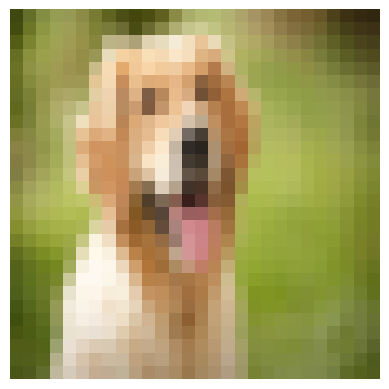

In [28]:
plt.imshow(img_tensor.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [29]:
batch = img_tensor.unsqueeze(0).to(device)

# Vision Transformer

In [30]:
class PatchEmbeddings(nn.Module):
    def __init__(
        self, in_channels: int, image_size: int, patch_size: int, embedding_size: int
    ):
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedding_size = embedding_size
        self.patch_num = (image_size // patch_size) ** 2

        # Equivalent of: patch flatten + linear projection
        self.projection = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_size,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x):
        x = self.projection(x)  # [btach_size, embedding_size, patch_num, patch_num]
        x = x.flatten(2).transpose(1, 2)  # [batch_size, patch_num, embedding_size]
        return x

In [31]:
patch_embeddings = PatchEmbeddings(
    in_channels=batch.shape[1],
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING_SIZE,
).to(device)

patch_embeddings(batch).shape  # [batch_size, patch_num, embedding_size]

torch.Size([1, 16, 128])

In [32]:
class EmbeddingLayer(nn.Module):
    def __init__(
        self, in_channels, image_size, patch_size, embedding_size, dropout_rate=0.1
    ):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(
            in_channels, image_size, patch_size, embedding_size
        )
        self.positional_embeddings = nn.Parameter(
            torch.randn(1, self.patch_embeddings.patch_num + 1, embedding_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_size))
        self.patch_num = self.patch_embeddings.patch_num + 1
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        cls_tokens = self.cls_token.expand((x.shape[0], 1, -1))
        x = self.patch_embeddings(x)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.positional_embeddings
        return self.dropout(x)

In [33]:
embedding_layer = EmbeddingLayer(
    in_channels=batch.shape[1],
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING_SIZE,
).to(device)

embedding_layer(batch).shape  # [batch_size, patch_num + 1, embedding_size]

torch.Size([1, 17, 128])

In [34]:
class AttentionLayer(nn.Module):
    def __init__(
        self, sequence_length, embedding_size, num_heads, dropout_rate=0.1, mask=False
    ):
        super().__init__()

        assert embedding_size % num_heads == 0, (
            "embedding_size must be divisible by num_heads"
        )

        self.mask = mask
        self.num_heads = num_heads
        self.head_size = embedding_size // num_heads
        self.sequence_length = sequence_length
        self.scale = self.head_size**-0.5

        self.embedding_size = embedding_size
        self.query_dense = nn.Linear(embedding_size, embedding_size)
        self.key_dense = nn.Linear(embedding_size, embedding_size)
        self.value_dense = nn.Linear(embedding_size, embedding_size)
        self.output_dense = nn.Linear(embedding_size, embedding_size)
        self.attn_dropout = nn.Dropout(dropout_rate)
        self.proj_dropout = nn.Dropout(dropout_rate)

    def split_heads(self, x):
        B, S, _ = x.size()
        return x.view(B, S, self.num_heads, self.head_size).transpose(1, 2)

    def forward(self, x):
        B, S, _ = x.size()

        Q = self.query_dense(x)
        K = self.key_dense(x)
        V = self.value_dense(x)

        Q_heads = self.split_heads(Q)  # (B, H, S, E/H)
        K_heads = self.split_heads(K)  # (B, H, S, E/H)
        V_heads = self.split_heads(V)  # (B, H, S, E/H)

        attention = (Q_heads @ K_heads.transpose(-2, -1)) * self.scale  # (B, H, S, S)

        if self.mask:
            mask = torch.tril(torch.ones(S, S, device=x.device)).view(1, 1, S, S)
            attention = attention.masked_fill(mask == 0, float("-inf"))

        attention_weights = F.softmax(attention, dim=-1)

        attention = self.attn_dropout(attention_weights) @ V_heads  # (B, H, S, E/H)

        out = attention.transpose(1, 2).contiguous().view(B, S, -1)
        out = self.output_dense(out)
        return self.proj_dropout(out), attention_weights

In [35]:
class FeedForward(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, embedding_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [36]:
class TransformerBlock(nn.Module):
    def __init__(
        self,
        sequence_length,
        embedding_size,
        num_heads,
        mlp_ratio=4.0,
        dropout_rate=0.1,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_size)
        self.attention_layer = AttentionLayer(
            sequence_length,
            embedding_size,
            num_heads,
            dropout_rate=dropout_rate,
            mask=False,
        )
        self.norm2 = nn.LayerNorm(embedding_size)
        self.feed_forward = FeedForward(
            embedding_size, int(embedding_size * mlp_ratio), dropout_rate=dropout_rate
        )
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        attention, attention_weights = self.attention_layer(self.norm1(x))
        x = x + attention
        x = x + self.feed_forward(self.norm2(x))
        return x, attention_weights

In [37]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        image_size: int,
        patch_size: int,
        embedding_size: int,
        num_heads: int,
        num_layers: int,
        mlp_ratio: float = 4.0,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.patch_size = patch_size
        self.image_size = image_size
        self.embedding_layer = EmbeddingLayer(
            in_channels, image_size, patch_size, embedding_size, dropout_rate
        )
        self.transformer_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    self.embedding_layer.patch_num,
                    embedding_size,
                    num_heads,
                    mlp_ratio,
                    dropout_rate,
                )
                for _ in range(num_layers)
            ]
        )
        self.norm = nn.LayerNorm(embedding_size)

    def forward(self, x):
        x = self.embedding_layer(x)  # [batch_size, patch_num + 1, embedding_size]
        attention_maps = []

        for transformer_block in self.transformer_blocks:
            x, attention_weights = transformer_block(x)
            attention_maps.append(attention_weights)

        x = self.norm(x)

        # [batch_size, patch_num + 1, embedding_size], [num_layers, num_heads, patch_num + 1, patch_num + 1]
        return x, attention_maps

In [38]:
class VisionTransformerClassifier(nn.Module):
    def __init__(
        self,
        in_channels: int,
        image_size: int,
        patch_size: int,
        embedding_size: int,
        num_heads: int,
        num_layers: int,
        num_classes: int,
        mlp_ratio: float = 4.0,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.vit = VisionTransformer(
            in_channels,
            image_size,
            patch_size,
            embedding_size,
            num_heads,
            num_layers,
            mlp_ratio,
            dropout_rate,
        )

        self.mlp_head = nn.Sequential(
            nn.Linear(embedding_size, embedding_size),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_size, num_classes),
        )
        self.patch_size = patch_size
        self.image_size = image_size

    def forward(self, x):
        x, attention_maps = self.vit(
            x
        )  # [batch_size, patch_num + 1, embedding_size], attention_maps
        cls_token = x[:, 0]  # [batch_size, embedding_size]
        logits = self.mlp_head(cls_token)  # [batch_size, num_classes]
        return logits, attention_maps

In [39]:
vit = VisionTransformerClassifier(
    in_channels=img_tensor.shape[0],
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE,
).to(device)

logits, attention_maps = vit(batch)
logits.shape, len(attention_maps), attention_maps[0].shape

(torch.Size([1, 10]), 12, torch.Size([1, 16, 17, 17]))

# Training

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = torchvision.datasets.MNIST(
    "../datasets", train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.MNIST(
    "../datasets", train=False, download=True, transform=test_transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    prefetch_factor=2,
    persistent_workers=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

In [42]:
next(iter(train_loader))[0].shape

torch.Size([256, 1, 28, 28])

In [43]:
vit = VisionTransformerClassifier(
    in_channels=1,
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE,
).to(device)

In [44]:
optimizer = torch.optim.AdamW(vit.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    steps_per_epoch=len(train_loader) // GRADIENT_ACCUMULATION_STEPS,
    epochs=NUM_EPOCHS,
    pct_start=0.1,
)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler(enabled=USE_AMP)

In [45]:
def get_gpu_utilization():
    try:
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        util = pynvml.nvmlDeviceGetUtilizationRates(handle)
        return util.gpu
    except Exception:
        return "N/A"

In [46]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [47]:
for epoch in range(NUM_EPOCHS):
    vit.train()
    train_loss = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Train]")
    for batch_idx, (data, targets) in enumerate(progress_bar):
        data = data.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.amp.autocast(device_type=device.type, enabled=USE_AMP):
            logits, _ = vit(data)
            loss = criterion(logits, targets) / GRADIENT_ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        is_update_step = (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0
        if is_update_step or batch_idx == len(train_loader) - 1:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(vit.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            if is_update_step:
                scheduler.step()
            optimizer.zero_grad()

        total += targets.size(0)
        _, preds = logits.max(1)
        correct += (preds == targets).sum().item()
        train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS

        progress_bar.set_postfix(
            {
                "loss": train_loss / (batch_idx + 1),
                "acc": correct / total * 100,
                "lr": scheduler.get_last_lr()[0],
                "GPU": get_gpu_utilization(),
            }
        )

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    vit.eval()
    val_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Valid]")
    with torch.no_grad():
        for data, targets in progress_bar:
            data = data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=device.type, enabled=USE_AMP):
                logits, _ = vit(data)
                val_loss += criterion(logits, targets).item()

            _, preds = logits.max(1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

            progress_bar.set_postfix(
                {
                    "loss": val_loss / (batch_idx + 1),
                    "acc": correct / total * 100,
                    "GPU": get_gpu_utilization(),
                }
            )

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total * 100
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > max(val_accuracies, default=0):
        torch.save(vit.state_dict(), "vit.pth")

    print(
        f"Epoch {epoch + 1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
    )

Epoch 1/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 31.46it/s, loss=0.378, acc=20.8, GPU=78] 


Epoch 1/50 - Train Loss: 2.2934, Train Acc: 13.13%, Val Loss: 2.2206, Val Acc: 20.83%


Epoch 2/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.42it/s, loss=0.293, acc=37, GPU=75]   


Epoch 2/50 - Train Loss: 2.0823, Train Acc: 24.59%, Val Loss: 1.7190, Val Acc: 37.00%


Epoch 3/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 34.05it/s, loss=0.167, acc=70, GPU=76]   


Epoch 3/50 - Train Loss: 1.6182, Train Acc: 43.49%, Val Loss: 0.9816, Val Acc: 69.97%


Epoch 4/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 30.86it/s, loss=0.0764, acc=87.4, GPU=65]


Epoch 4/50 - Train Loss: 1.0332, Train Acc: 66.15%, Val Loss: 0.4490, Val Acc: 87.40%


Epoch 5/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.55it/s, loss=0.0384, acc=93.7, GPU=77] 


Epoch 5/50 - Train Loss: 0.6212, Train Acc: 80.17%, Val Loss: 0.2258, Val Acc: 93.66%


Epoch 6/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.02it/s, loss=0.0274, acc=95, GPU=64]   


Epoch 6/50 - Train Loss: 0.4166, Train Acc: 86.97%, Val Loss: 0.1611, Val Acc: 95.00%


Epoch 7/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.32it/s, loss=0.0252, acc=95.4, GPU=79]


Epoch 7/50 - Train Loss: 0.3192, Train Acc: 89.94%, Val Loss: 0.1482, Val Acc: 95.38%


Epoch 8/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 27.52it/s, loss=0.0173, acc=96.6, GPU=73] 


Epoch 8/50 - Train Loss: 0.2589, Train Acc: 91.93%, Val Loss: 0.1015, Val Acc: 96.57%


Epoch 9/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.36it/s, loss=0.0142, acc=97.2, GPU=72] 


Epoch 9/50 - Train Loss: 0.2195, Train Acc: 93.07%, Val Loss: 0.0834, Val Acc: 97.19%


Epoch 10/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 31.93it/s, loss=0.014, acc=97.5, GPU=67]  


Epoch 10/50 - Train Loss: 0.1963, Train Acc: 93.91%, Val Loss: 0.0822, Val Acc: 97.52%


Epoch 11/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.56it/s, loss=0.0111, acc=98.1, GPU=66] 


Epoch 11/50 - Train Loss: 0.1759, Train Acc: 94.47%, Val Loss: 0.0651, Val Acc: 98.09%


Epoch 12/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.85it/s, loss=0.0111, acc=97.9, GPU=73] 


Epoch 12/50 - Train Loss: 0.1593, Train Acc: 95.07%, Val Loss: 0.0654, Val Acc: 97.94%


Epoch 13/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.88it/s, loss=0.0108, acc=98, GPU=81]   


Epoch 13/50 - Train Loss: 0.1470, Train Acc: 95.42%, Val Loss: 0.0633, Val Acc: 97.97%


Epoch 14/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.37it/s, loss=0.0113, acc=98, GPU=62]   


Epoch 14/50 - Train Loss: 0.1394, Train Acc: 95.64%, Val Loss: 0.0667, Val Acc: 97.95%


Epoch 15/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.69it/s, loss=0.00984, acc=98.1, GPU=79]


Epoch 15/50 - Train Loss: 0.1320, Train Acc: 95.80%, Val Loss: 0.0578, Val Acc: 98.13%


Epoch 16/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.47it/s, loss=0.00843, acc=98.4, GPU=66]


Epoch 16/50 - Train Loss: 0.1267, Train Acc: 96.09%, Val Loss: 0.0495, Val Acc: 98.43%


Epoch 17/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.85it/s, loss=0.00816, acc=98.5, GPU=68]


Epoch 17/50 - Train Loss: 0.1162, Train Acc: 96.45%, Val Loss: 0.0479, Val Acc: 98.45%


Epoch 18/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.03it/s, loss=0.00769, acc=98.6, GPU=68]


Epoch 18/50 - Train Loss: 0.1088, Train Acc: 96.62%, Val Loss: 0.0452, Val Acc: 98.61%


Epoch 19/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.56it/s, loss=0.0078, acc=98.7, GPU=69] 


Epoch 19/50 - Train Loss: 0.1069, Train Acc: 96.64%, Val Loss: 0.0458, Val Acc: 98.69%


Epoch 20/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 31.78it/s, loss=0.00789, acc=98.6, GPU=75]


Epoch 20/50 - Train Loss: 0.1031, Train Acc: 96.79%, Val Loss: 0.0464, Val Acc: 98.59%


Epoch 21/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.38it/s, loss=0.00698, acc=98.7, GPU=66]


Epoch 21/50 - Train Loss: 0.0986, Train Acc: 96.93%, Val Loss: 0.0410, Val Acc: 98.68%


Epoch 22/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.27it/s, loss=0.00665, acc=98.7, GPU=65]


Epoch 22/50 - Train Loss: 0.0968, Train Acc: 97.04%, Val Loss: 0.0391, Val Acc: 98.73%


Epoch 23/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.22it/s, loss=0.00681, acc=98.8, GPU=81]


Epoch 23/50 - Train Loss: 0.0931, Train Acc: 97.10%, Val Loss: 0.0400, Val Acc: 98.76%


Epoch 24/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.53it/s, loss=0.00689, acc=98.8, GPU=80]


Epoch 24/50 - Train Loss: 0.0890, Train Acc: 97.19%, Val Loss: 0.0405, Val Acc: 98.76%


Epoch 25/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.80it/s, loss=0.00666, acc=98.8, GPU=73]


Epoch 25/50 - Train Loss: 0.0866, Train Acc: 97.28%, Val Loss: 0.0391, Val Acc: 98.78%


Epoch 26/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.23it/s, loss=0.00682, acc=98.8, GPU=69]


Epoch 26/50 - Train Loss: 0.0834, Train Acc: 97.36%, Val Loss: 0.0401, Val Acc: 98.76%


Epoch 27/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.70it/s, loss=0.0058, acc=98.9, GPU=68] 


Epoch 27/50 - Train Loss: 0.0807, Train Acc: 97.51%, Val Loss: 0.0341, Val Acc: 98.93%


Epoch 28/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.71it/s, loss=0.00677, acc=98.7, GPU=83]


Epoch 28/50 - Train Loss: 0.0799, Train Acc: 97.49%, Val Loss: 0.0398, Val Acc: 98.66%


Epoch 29/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 31.58it/s, loss=0.00582, acc=98.9, GPU=59]


Epoch 29/50 - Train Loss: 0.0777, Train Acc: 97.63%, Val Loss: 0.0342, Val Acc: 98.88%


Epoch 30/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.03it/s, loss=0.00611, acc=98.9, GPU=81]


Epoch 30/50 - Train Loss: 0.0774, Train Acc: 97.58%, Val Loss: 0.0359, Val Acc: 98.86%


Epoch 31/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 26.48it/s, loss=0.00608, acc=98.9, GPU=78]


Epoch 31/50 - Train Loss: 0.0747, Train Acc: 97.72%, Val Loss: 0.0357, Val Acc: 98.89%


Epoch 32/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.86it/s, loss=0.00567, acc=98.9, GPU=81]


Epoch 32/50 - Train Loss: 0.0706, Train Acc: 97.79%, Val Loss: 0.0333, Val Acc: 98.87%


Epoch 33/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.46it/s, loss=0.00558, acc=98.9, GPU=66]


Epoch 33/50 - Train Loss: 0.0714, Train Acc: 97.72%, Val Loss: 0.0328, Val Acc: 98.89%


Epoch 34/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.67it/s, loss=0.00579, acc=98.9, GPU=74]


Epoch 34/50 - Train Loss: 0.0702, Train Acc: 97.77%, Val Loss: 0.0340, Val Acc: 98.90%


Epoch 35/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.57it/s, loss=0.00536, acc=99, GPU=64]  


Epoch 35/50 - Train Loss: 0.0689, Train Acc: 97.87%, Val Loss: 0.0315, Val Acc: 98.96%


Epoch 36/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 31.20it/s, loss=0.00532, acc=98.9, GPU=63]


Epoch 36/50 - Train Loss: 0.0653, Train Acc: 97.97%, Val Loss: 0.0312, Val Acc: 98.92%


Epoch 37/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.37it/s, loss=0.00567, acc=99, GPU=81]  


Epoch 37/50 - Train Loss: 0.0644, Train Acc: 98.01%, Val Loss: 0.0333, Val Acc: 98.95%


Epoch 38/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 34.29it/s, loss=0.00522, acc=99, GPU=78]  


Epoch 38/50 - Train Loss: 0.0652, Train Acc: 97.95%, Val Loss: 0.0307, Val Acc: 98.99%


Epoch 39/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.16it/s, loss=0.00535, acc=99, GPU=65]  


Epoch 39/50 - Train Loss: 0.0621, Train Acc: 98.03%, Val Loss: 0.0314, Val Acc: 98.97%


Epoch 40/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.10it/s, loss=0.00536, acc=99, GPU=71]  


Epoch 40/50 - Train Loss: 0.0629, Train Acc: 97.94%, Val Loss: 0.0315, Val Acc: 98.95%


Epoch 41/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.38it/s, loss=0.0051, acc=99, GPU=68]   


Epoch 41/50 - Train Loss: 0.0617, Train Acc: 98.12%, Val Loss: 0.0300, Val Acc: 99.00%


Epoch 42/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.02it/s, loss=0.00529, acc=99, GPU=65]  


Epoch 42/50 - Train Loss: 0.0603, Train Acc: 98.12%, Val Loss: 0.0311, Val Acc: 98.95%


Epoch 43/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 32.96it/s, loss=0.00517, acc=99, GPU=81]  


Epoch 43/50 - Train Loss: 0.0614, Train Acc: 98.10%, Val Loss: 0.0304, Val Acc: 98.99%


Epoch 44/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 34.50it/s, loss=0.00499, acc=99, GPU=81]  


Epoch 44/50 - Train Loss: 0.0614, Train Acc: 98.06%, Val Loss: 0.0293, Val Acc: 99.00%


Epoch 45/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.57it/s, loss=0.00492, acc=99, GPU=80]  


Epoch 45/50 - Train Loss: 0.0608, Train Acc: 98.06%, Val Loss: 0.0289, Val Acc: 99.02%


Epoch 46/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.49it/s, loss=0.00505, acc=99, GPU=68]  


Epoch 46/50 - Train Loss: 0.0578, Train Acc: 98.16%, Val Loss: 0.0297, Val Acc: 98.99%


Epoch 47/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.14it/s, loss=0.00501, acc=99, GPU=73]  


Epoch 47/50 - Train Loss: 0.0610, Train Acc: 98.06%, Val Loss: 0.0294, Val Acc: 99.00%


Epoch 48/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.08it/s, loss=0.00499, acc=99, GPU=81]  


Epoch 48/50 - Train Loss: 0.0581, Train Acc: 98.17%, Val Loss: 0.0293, Val Acc: 98.99%


Epoch 49/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.59it/s, loss=0.00501, acc=99, GPU=71]  


Epoch 49/50 - Train Loss: 0.0607, Train Acc: 98.02%, Val Loss: 0.0294, Val Acc: 98.99%


Epoch 50/50 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.20it/s, loss=0.00501, acc=99, GPU=66]  

Epoch 50/50 - Train Loss: 0.0580, Train Acc: 98.13%, Val Loss: 0.0294, Val Acc: 98.99%


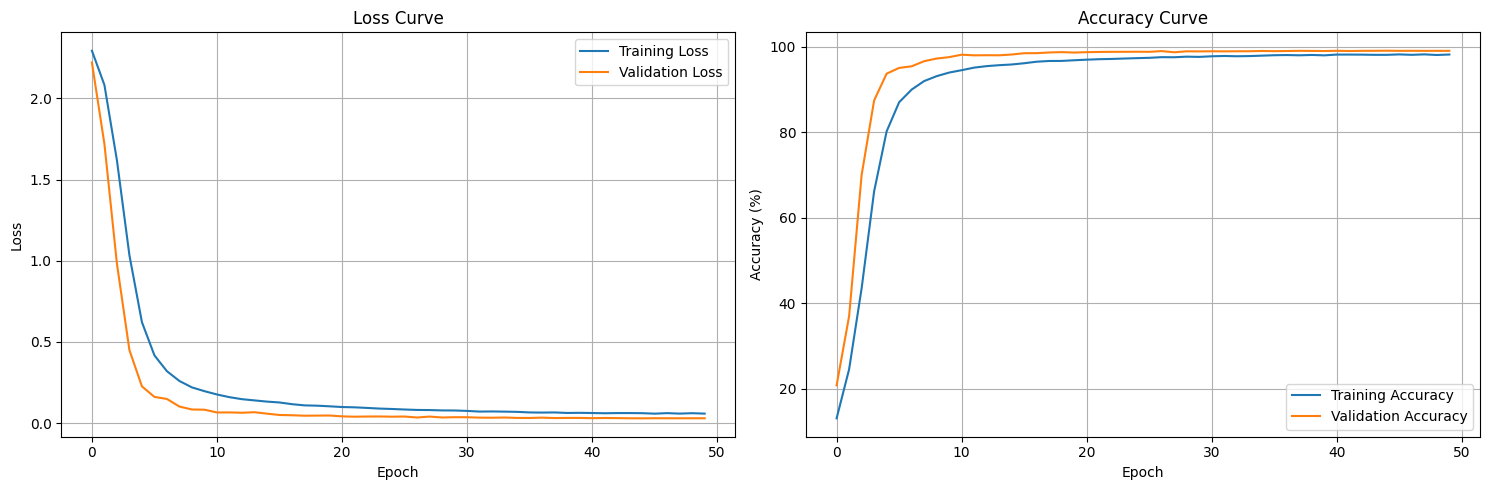

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curve")
plt.grid(True)

plt.tight_layout()
plt.show()

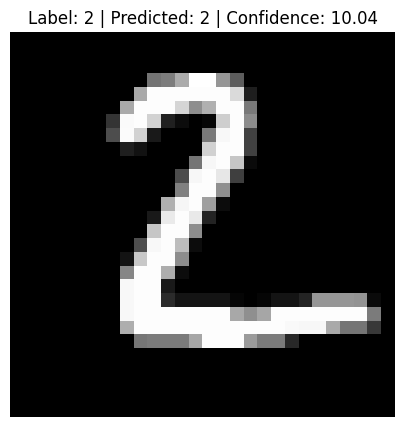

In [52]:
image, label = next(iter(test_loader))
sample_image = image[1].unsqueeze(0).to(device)
sample_label = label[1].item()
vit.eval()
with torch.no_grad():
    outputs, attention_maps = vit(sample_image)

predicted_class = outputs.argmax(dim=1).item()
confidence = outputs[0, predicted_class].item()

plt.figure(figsize=(5, 5))
plt.imshow(image[1].squeeze().cpu().numpy(), cmap="gray")
plt.title(
    f"Label: {sample_label} | Predicted: {predicted_class} | Confidence: {confidence:.2f}"
)
plt.axis("off")
plt.show()

# Attention map visualization

In [ ]:
def visualize_attention_maps(image, attention_maps, layer_idx=0):
    num_heads = attention_maps[layer_idx].shape[1]

    fig = plt.figure(figsize=(15, 6))

    if image.shape[1] == 1:  # Grayscale image
        img = image[0, 0].cpu().numpy()
        ax = fig.add_subplot(1, num_heads + 2, 1)
        ax.imshow(img, cmap="gray")
        ax.set_title("Original Image", fontsize=12)
        ax.axis("off")
    else:  # RGB image
        img = image[0].permute(1, 2, 0).cpu().numpy()
        ax = fig.add_subplot(1, num_heads + 2, 1)
        ax.imshow(img)
        ax.set_title("Original Image", fontsize=12)
        ax.axis("off")

    upscaled_attns = []
    for head_idx in range(num_heads):
        attn = attention_maps[layer_idx][0, head_idx].cpu().numpy()
        cls_attn = attn[0, 1:]

        n_patches = int(np.sqrt(len(cls_attn)))
        attn_map = cls_attn.reshape(n_patches, n_patches)

        upscaled_attn = scipy.ndimage.zoom(
            attn_map,
            (img.shape[0] / n_patches, img.shape[1] / n_patches),
            order=1,
        )
        upscaled_attns.append(upscaled_attn)

        ax = fig.add_subplot(1, num_heads + 2, head_idx + 2)
        ax.imshow(upscaled_attn, cmap="hot")
        ax.set_title(f"Head {head_idx}", fontsize=12)
        ax.axis("off")

    combined_attn = np.mean(upscaled_attns, axis=0)
    ax = fig.add_subplot(1, num_heads + 2, num_heads + 2)
    if image.shape[1] == 1:
        ax.imshow(img, cmap="gray")
        ax.imshow(combined_attn, cmap="hot", alpha=0.6)
    else:
        ax.imshow(img)
        ax.imshow(combined_attn, cmap="hot", alpha=0.6)
    ax.set_title("Combined Overlay", fontsize=12)
    ax.axis("off")

    plt.tight_layout()
    plt.suptitle(f"Attention Maps for Layer {layer_idx}", fontsize=14)
    plt.subplots_adjust(top=1.3)
    plt.show()

    return upscaled_attns

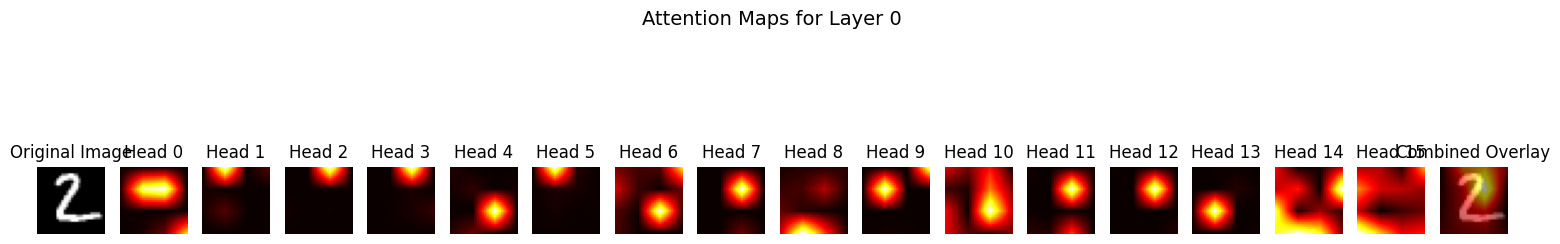

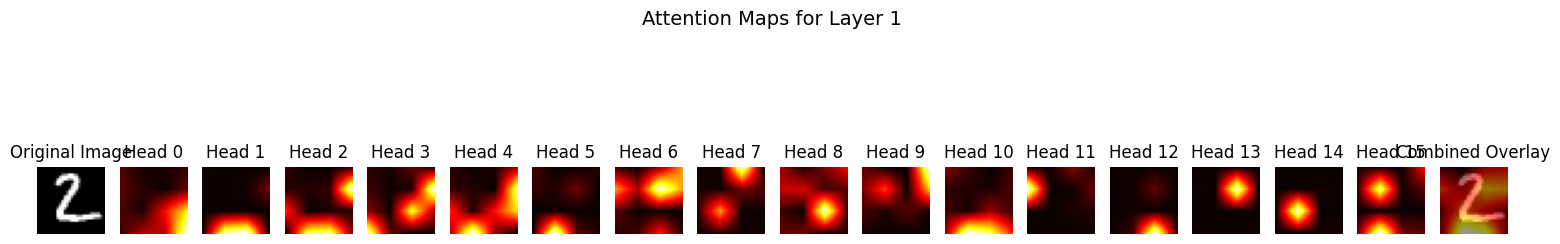

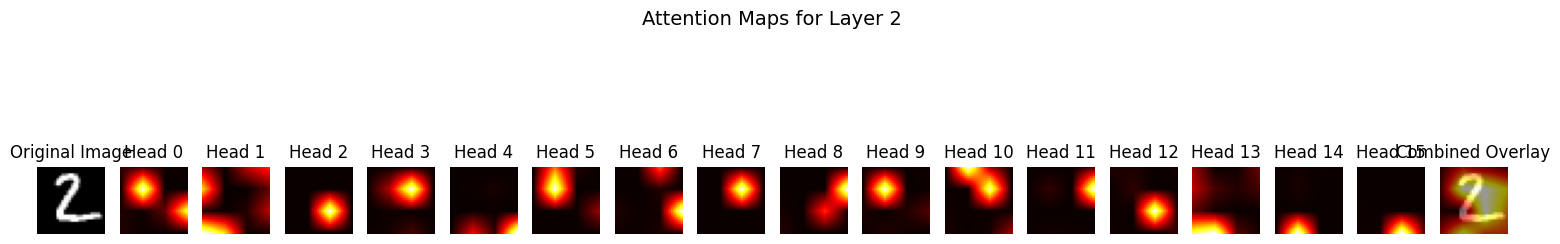

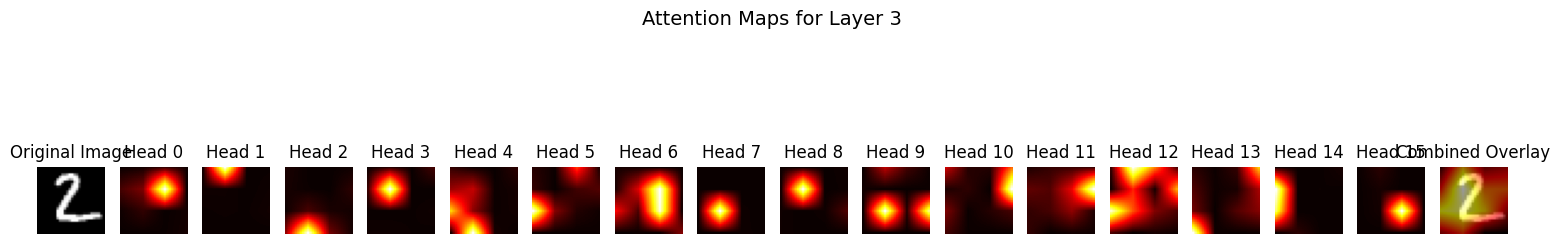

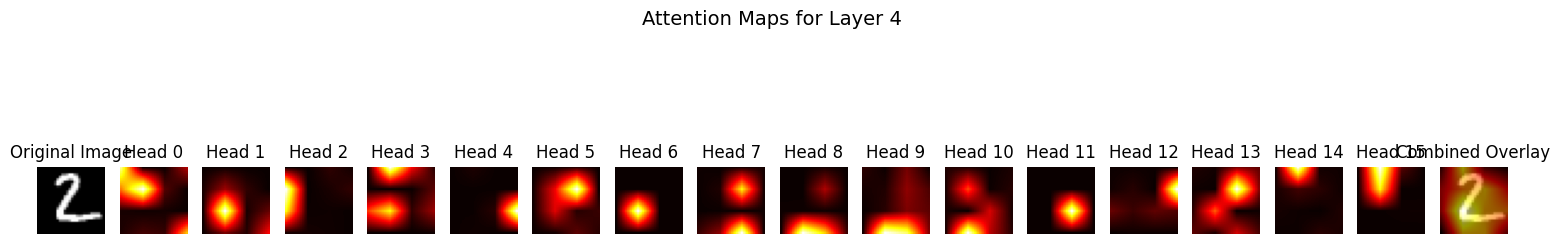

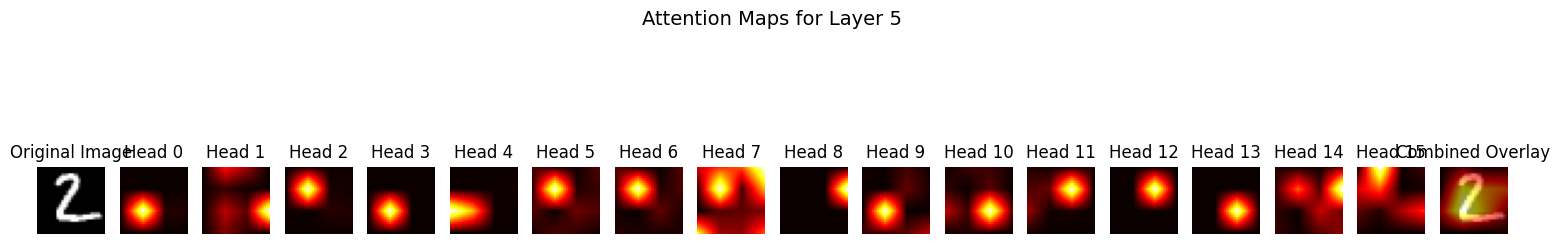

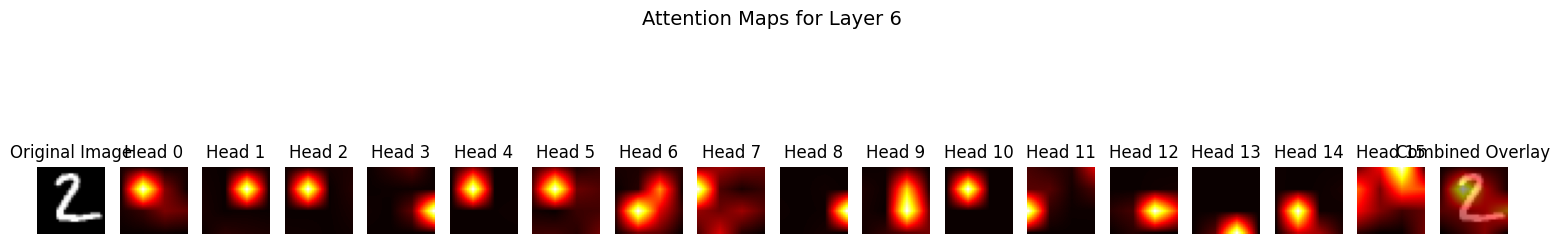

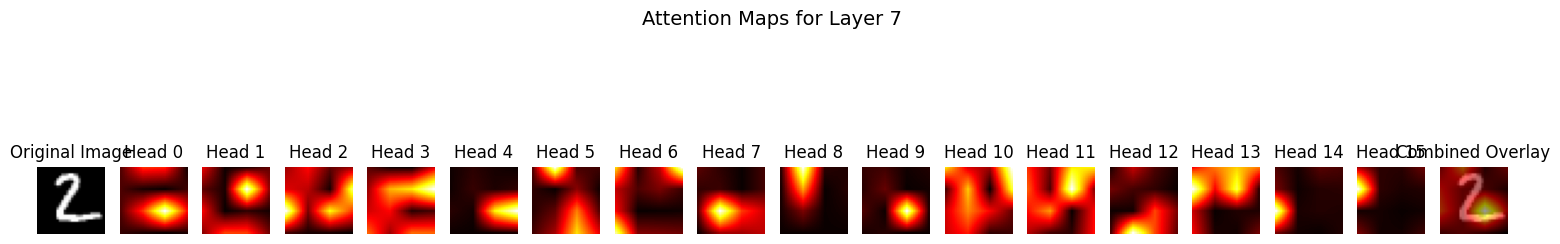

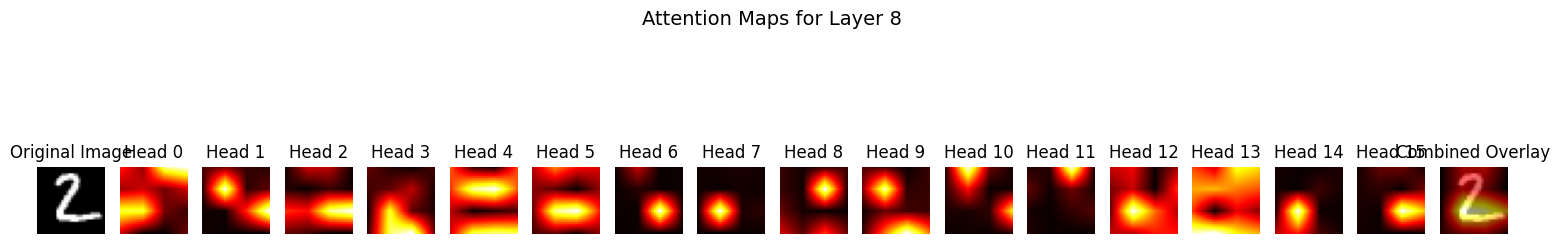

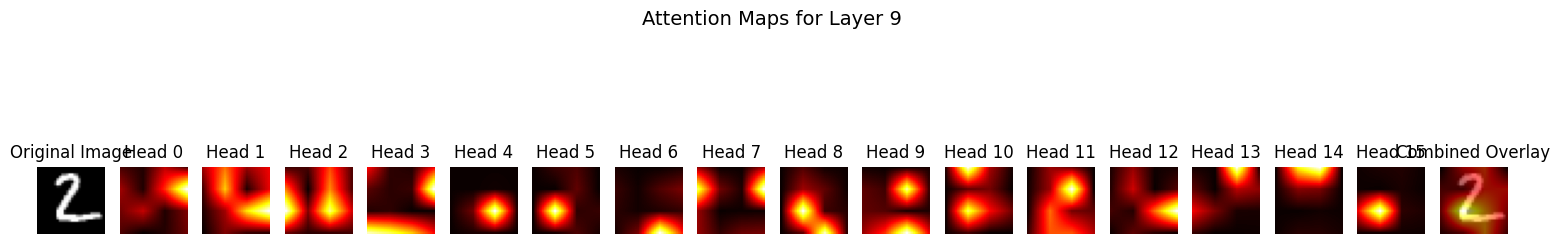

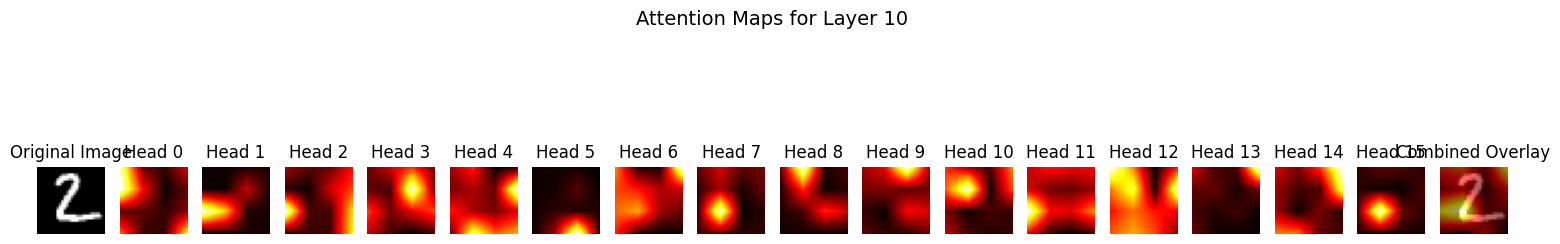

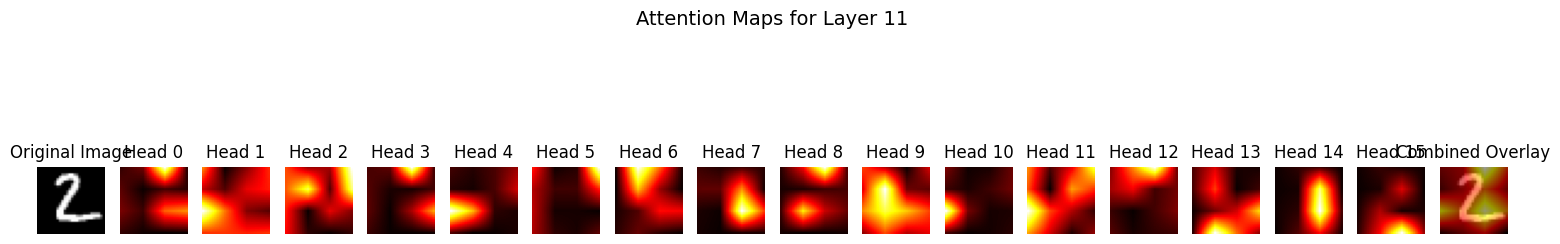

In [60]:
for layer_idx in range(len(attention_maps)):
    _ = visualize_attention_maps(sample_image, attention_maps, layer_idx=layer_idx)